# Inbalanced learn examples

 Using the module inbalanced learn to balanced our dataset (increase positives)
 To install "pip install -U imbalanced-learn" or "conda install -c glemaitre imbalanced-learn"

In [1]:
import imblearn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [4]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "/Users/briannaburton/Documents/Masters/S2-Cassino/Advanced-Image-Analysis/AIA-2018/examples/feature-tables/train-data_1527086478.csv"
dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3232
Number of regions in dataset 02: 3144


Unbalanced Data Set


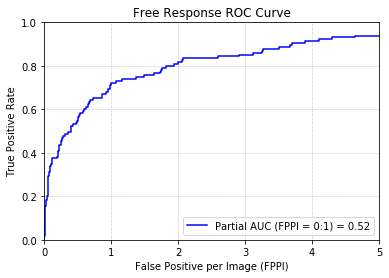

Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.52399
RandomOverSampler


AttributeError: module 'immas.classification' has no attribute 'oversampled_run_SVM'

In [5]:
print("Unbalanced Data Set")
_,_,_,_,_ = classification.run_SVM (dataset01, dataset02, kernel='rbf', features='all_except_LBP')
print("RandomOverSampler")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=0), kernel='rbf', features='all_except_LBP')
print("ADASYN")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=0), kernel='rbf', features='all_except_LBP')
print("SMOTE with regular algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0), kernel='rbf', features='all_except_LBP')
print("SMOTE with borderline1 algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'borderline1'), kernel='rbf', features='all_except_LBP')
print("SMOTE with borderline2 algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'borderline2'), kernel='rbf', features='all_except_LBP')
print("SMOTE with SVM algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'svm'), kernel='rbf', features='all_except_LBP')
print("SMOTEENN(random_state=42)")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42), kernel='rbf', features='all_except_LBP')
print("SMOTETomek(random_state=42)")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42), kernel='rbf', features='all_except_LBP')

In [7]:
# Testing for Random Over Sampler
print('random_state=0')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=0), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print('random_state=None')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=None), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print('random_state=10')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("ratio ='minority', random_state=0")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=0), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("ratio ='minority', random_state=None")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=None), kernel='rbf', features='all_except_LBP',show_plot = 'no')

random_state=0
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.51968
random_state=None
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52011
random_state=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52028
ratio ='minority', random_state=0
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.51983
ratio ='minority', random_state=None
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.51958


In [9]:
# Testing for ADASYN
print('randomstate=None, n_neighbors = 1')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 1), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print('randomstate=None, n_neighbors = 5')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 5), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print('randomstate=None, n_neighbors = 10')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print('randomstate=None, n_neighbors = 21')
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 21), kernel='rbf', features='all_except_LBP',show_plot = 'no')

randomstate=None, n_neighbors = 5
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54291
randomstate=None, n_neighbors = 1
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53979
randomstate=None, n_neighbors = 10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54738
randomstate=None, n_neighbors = 20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54191


In [10]:
#Testing SMOTE with regular algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), kernel='rbf', features='all_except_LBP',show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54520
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54647
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54694
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54867
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54571
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [11]:
# Testing SMOTE with borderline1 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features='all_except_LBP',show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53820
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54006
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53071
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54405
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.52036
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [12]:
# Testing SMOTE with borderline2 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features='all_except_LBP',show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.52481
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53048
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54284
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54148
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52653
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [13]:
# Testing SMOTE with SVM algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), kernel='rbf', features='all_except_LBP',show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53879
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54520
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53468
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55194
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.52286
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 